In [1]:
import os
import numpy as np
import pandas as pd
import gc
import time
from contextlib import contextmanager
#from lightgbm import LGBMClassifier
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import train_test_split 
from sklearn.model_selection import KFold, StratifiedKFold
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline 

SRC_PATH = "./dataset/home_credit/sources"
OUT_PATH = "./dataset/home_credit/outputs"
print(os.listdir(SRC_PATH))

### Common Functions

In [3]:
def get_misstable(df):
    num_rows = len(df)
    num_null = df.isnull().sum()
    ratio_null = num_null / num_rows
    unique_counts = df.apply(lambda x: len(x.value_counts()), axis=0)
    misstable = pd.concat([num_null, ratio_null, unique_counts, df.dtypes], axis=1)
    misstable.columns = ['NaN Freq.', 'NaN Ratio', 'Levels', 'Type']
    return misstable    

# Fill nan values
def fillna_df(df, verbose=False):
    cat_cols_object = df.dtypes[df.dtypes == 'object'].index
    cat_cols_int = df.dtypes[df.dtypes == 'int64'].index
    numeric_cols = df.dtypes[df.dtypes == 'float64'].index
    
    if verbose:
        display(get_misstable(df[cat_cols_object]))
        display(get_misstable(df[cat_cols_int]))
        display(get_misstable(df[numeric_cols]))

    df[cat_cols_object] = df[cat_cols_object].fillna('etc')
    df[cat_cols_int] = df[cat_cols_int].fillna(0)
    df[numeric_cols] = df[numeric_cols].fillna(0) 
    
    return df, cat_cols_object, cat_cols_int, numeric_cols

# Label encoding 
def labelencoder_fit(df):
    from sklearn.preprocessing import LabelEncoder
    from collections import defaultdict
    le_dict = defaultdict(LabelEncoder)
    df_out = df.apply(lambda x: le_dict[x.name].fit_transform(x))
    return df_out, le_dict


def save_strlist(filename, my_list):
    with open(filename, mode='w', encoding='utf-8') as f:
        f.write('\n'.join(my_list))
        
        
def load_strlist(filename):
    with open(filename, mode='r', encoding='utf-8') as f:
        lines = f.read().splitlines()
    return lines


def save_df_columns(df, path, uniq_name):
    filename = '{}/{}_columns.txt'.format(path, uniq_name)
    save_strlist(filename, df.columns.values)
    
    cat_cols_object = df.dtypes[df.dtypes == 'object'].index
    cat_cols_int = df.dtypes[df.dtypes == 'int64'].index
    numeric_cols = df.dtypes[df.dtypes == 'float64'].index

    if cat_cols_object.empty is False:
        filename = '{}/{}_cat_obj_columns.txt'.format(path, uniq_name)
        save_strlist(filename, cat_cols_object.values)
            
    if cat_cols_int.empty is False:
        filename = '{}/{}_cat_int_columns.txt'.format(path, uniq_name)
        save_strlist(filename, cat_cols_int.values)  
            
    if numeric_cols.empty is False:
        filename = '{}/{}_numeric_columns.txt'.format(path, uniq_name)
        save_strlist(filename, numeric_cols.values)    
       
    
def load_df_columns(path, list_columns_load, mode=None):
    suffix = '_columns' if mode is None else '_{}_columns'.format(mode)

    dict_columns = {}
    for i, v in enumerate(list_columns_load):
        filename = '{}/{}.txt'.format(PATH + '/meta', v + suffix)
        print(filename)
        dict_columns[v] = load_strlist(filename)

    return dict_columns 

### Data Preprossing Functions
- Modified code based on the below reference
- Reference https://www.kaggle.com/poohtls/fork-of-fork-lightgbm-with-simple-features/code

In [4]:
@contextmanager
def timer(title):
    t0 = time.time()
    yield
    print("{} - done in {:.0f}s".format(title, time.time() - t0))

# One-hot encoding for categorical columns with get_dummies
def one_hot_encoder(df, nan_as_category = True):
    original_columns = list(df.columns)
    categorical_columns = [col for col in df.columns if df[col].dtype == 'object']
    df = pd.get_dummies(df, columns= categorical_columns, dummy_na= nan_as_category)
    new_columns = [c for c in df.columns if c not in original_columns]
    return df, new_columns

# Preprocess application_train.csv and application_test.csv
def application_train_test(num_rows = None, use_derived_features = True, nan_as_category = False):
    # Read data and merge
    df = pd.read_csv(SRC_PATH + '/application_train.csv', nrows= num_rows)
    test_df = pd.read_csv(SRC_PATH + '/application_test.csv', nrows= num_rows)
    print("Train samples: {}, test samples: {}".format(len(df), len(test_df)))
    df = df.append(test_df).reset_index(drop=True)
    # Optional: Remove 4 applications with XNA CODE_GENDER (train set)
    df = df[df['CODE_GENDER'] != 'XNA']
    
    docs = [_f for _f in df.columns if 'FLAG_DOC' in _f]
    live = [_f for _f in df.columns if ('FLAG_' in _f) & ('FLAG_DOC' not in _f) & ('_FLAG_' not in _f)]
    
    # NaN values for DAYS_EMPLOYED: 365.243 -> nan
    df['DAYS_EMPLOYED'].replace(365243, np.nan, inplace= True)

    if use_derived_features:
        inc_by_org = df[['AMT_INCOME_TOTAL', 'ORGANIZATION_TYPE']].groupby('ORGANIZATION_TYPE').median()['AMT_INCOME_TOTAL']
        df['NEW_CREDIT_TO_ANNUITY_RATIO'] = df['AMT_CREDIT'] / df['AMT_ANNUITY']
        df['NEW_CREDIT_TO_GOODS_RATIO'] = df['AMT_CREDIT'] / df['AMT_GOODS_PRICE']
        df['NEW_DOC_IND_KURT'] = df[docs].kurtosis(axis=1)
        df['NEW_LIVE_IND_SUM'] = df[live].sum(axis=1)
        df['NEW_INC_PER_CHLD'] = df['AMT_INCOME_TOTAL'] / (1 + df['CNT_CHILDREN'])
        df['NEW_INC_BY_ORG'] = df['ORGANIZATION_TYPE'].map(inc_by_org)
        df['NEW_EMPLOY_TO_BIRTH_RATIO'] = df['DAYS_EMPLOYED'] / df['DAYS_BIRTH']
        df['NEW_ANNUITY_TO_INCOME_RATIO'] = df['AMT_ANNUITY'] / (1 + df['AMT_INCOME_TOTAL'])
        df['NEW_SOURCES_PROD'] = df['EXT_SOURCE_1'] * df['EXT_SOURCE_2'] * df['EXT_SOURCE_3']
        df['NEW_EXT_SOURCES_MEAN'] = df[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']].mean(axis=1)
        df['NEW_SCORES_STD'] = df[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']].std(axis=1)
        df['NEW_SCORES_STD'] = df['NEW_SCORES_STD'].fillna(df['NEW_SCORES_STD'].mean())
        df['NEW_CAR_TO_BIRTH_RATIO'] = df['OWN_CAR_AGE'] / df['DAYS_BIRTH']
        df['NEW_CAR_TO_EMPLOY_RATIO'] = df['OWN_CAR_AGE'] / df['DAYS_EMPLOYED']
        df['NEW_PHONE_TO_BIRTH_RATIO'] = df['DAYS_LAST_PHONE_CHANGE'] / df['DAYS_BIRTH']
        df['NEW_PHONE_TO_BIRTH_RATIO_EMPLOYER'] = df['DAYS_LAST_PHONE_CHANGE'] / df['DAYS_EMPLOYED']
        df['NEW_CREDIT_TO_INCOME_RATIO'] = df['AMT_CREDIT'] / df['AMT_INCOME_TOTAL']

    # Categorical features with Binary encode (0 or 1; two categories)
    for bin_feature in ['CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY']:
        df[bin_feature], uniques = pd.factorize(df[bin_feature])
    # Categorical features with One-Hot encode
    df, cat_cols = one_hot_encoder(df, nan_as_category)
    df = df.drop(docs, axis=1)
    del test_df
    gc.collect()
    return df

# Preprocess bureau.csv and bureau_balance.csv
def bureau_and_balance(num_rows = None, nan_as_category = True):
    bureau = pd.read_csv(SRC_PATH + '/bureau.csv', nrows = num_rows)
    bb = pd.read_csv(SRC_PATH + '/bureau_balance.csv', nrows = num_rows)
    bb, bb_cat = one_hot_encoder(bb, nan_as_category)
    bureau, bureau_cat = one_hot_encoder(bureau, nan_as_category)
    
    # Bureau balance: Perform aggregations and merge with bureau.csv
    bb_aggregations = {'MONTHS_BALANCE': ['min', 'max', 'size']}
    for col in bb_cat:
        bb_aggregations[col] = ['mean']
    bb_agg = bb.groupby('SK_ID_BUREAU').agg(bb_aggregations)
    bb_agg.columns = pd.Index([e[0] + "_" + e[1].upper() for e in bb_agg.columns.tolist()])
    bureau = bureau.join(bb_agg, how='left', on='SK_ID_BUREAU')
    bureau.drop(['SK_ID_BUREAU'], axis=1, inplace= True)
    del bb, bb_agg
    gc.collect()
    
    # Bureau and bureau_balance numeric features
    num_aggregations = {
        'DAYS_CREDIT': ['mean', 'var'],
        'DAYS_CREDIT_ENDDATE': ['mean'],
        'DAYS_CREDIT_UPDATE': ['mean'],
        'CREDIT_DAY_OVERDUE': ['mean'],
        'AMT_CREDIT_MAX_OVERDUE': ['mean'],
        'AMT_CREDIT_SUM': ['mean', 'sum'],
        'AMT_CREDIT_SUM_DEBT': ['mean', 'sum'],
        'AMT_CREDIT_SUM_OVERDUE': ['mean'],
        'AMT_CREDIT_SUM_LIMIT': ['mean', 'sum'],
        'AMT_ANNUITY': ['max', 'mean'],
        'CNT_CREDIT_PROLONG': ['sum'],
        'MONTHS_BALANCE_MIN': ['min'],
        'MONTHS_BALANCE_MAX': ['max'],
        'MONTHS_BALANCE_SIZE': ['mean', 'sum']
    }
    # Bureau and bureau_balance categorical features
    cat_aggregations = {}
    for cat in bureau_cat: cat_aggregations[cat] = ['mean']
    for cat in bb_cat: cat_aggregations[cat + "_MEAN"] = ['mean']
    
    bureau_agg = bureau.groupby('SK_ID_CURR').agg({**num_aggregations, **cat_aggregations})
    bureau_agg.columns = pd.Index(['BURO_' + e[0] + "_" + e[1].upper() for e in bureau_agg.columns.tolist()])
    # Bureau: Active credits - using only numerical aggregations
    active = bureau[bureau['CREDIT_ACTIVE_Active'] == 1]
    active_agg = active.groupby('SK_ID_CURR').agg(num_aggregations)
    active_agg.columns = pd.Index(['ACTIVE_' + e[0] + "_" + e[1].upper() for e in active_agg.columns.tolist()])
    bureau_agg = bureau_agg.join(active_agg, how='left', on='SK_ID_CURR')
    del active, active_agg
    gc.collect()
    # Bureau: Closed credits - using only numerical aggregations
    closed = bureau[bureau['CREDIT_ACTIVE_Closed'] == 1]
    closed_agg = closed.groupby('SK_ID_CURR').agg(num_aggregations)
    closed_agg.columns = pd.Index(['CLOSED_' + e[0] + "_" + e[1].upper() for e in closed_agg.columns.tolist()])
    bureau_agg = bureau_agg.join(closed_agg, how='left', on='SK_ID_CURR')
    del closed, closed_agg, bureau
    gc.collect()
    return bureau_agg

# Preprocess previous_applications.csv
def previous_applications(num_rows = None, nan_as_category = True):
    prev = pd.read_csv(SRC_PATH + '/previous_application.csv', nrows = num_rows)
    prev, cat_cols = one_hot_encoder(prev, nan_as_category= True)
    # Days 365.243 values -> nan
    prev['DAYS_FIRST_DRAWING'].replace(365243, np.nan, inplace= True)
    prev['DAYS_FIRST_DUE'].replace(365243, np.nan, inplace= True)
    prev['DAYS_LAST_DUE_1ST_VERSION'].replace(365243, np.nan, inplace= True)
    prev['DAYS_LAST_DUE'].replace(365243, np.nan, inplace= True)
    prev['DAYS_TERMINATION'].replace(365243, np.nan, inplace= True)
    # Add feature: value ask / value received percentage
    prev['APP_CREDIT_PERC'] = prev['AMT_APPLICATION'] / prev['AMT_CREDIT']
    # Previous applications numeric features
    num_aggregations = {
        'AMT_ANNUITY': ['max', 'mean'],
        'AMT_APPLICATION': ['max','mean'],
        'AMT_CREDIT': ['max', 'mean'],
        'APP_CREDIT_PERC': ['max', 'mean'],
        'AMT_DOWN_PAYMENT': ['max', 'mean'],
        'AMT_GOODS_PRICE': ['max', 'mean'],
        'HOUR_APPR_PROCESS_START': ['max', 'mean'],
        'RATE_DOWN_PAYMENT': ['max', 'mean'],
        'DAYS_DECISION': ['max', 'mean'],
        'CNT_PAYMENT': ['mean', 'sum'],
    }
    # Previous applications categorical features
    cat_aggregations = {}
    for cat in cat_cols:
        cat_aggregations[cat] = ['mean']
    
    prev_agg = prev.groupby('SK_ID_CURR').agg({**num_aggregations, **cat_aggregations})
    prev_agg.columns = pd.Index(['PREV_' + e[0] + "_" + e[1].upper() for e in prev_agg.columns.tolist()])
    # Previous Applications: Approved Applications - only numerical features
    approved = prev[prev['NAME_CONTRACT_STATUS_Approved'] == 1]
    approved_agg = approved.groupby('SK_ID_CURR').agg(num_aggregations)
    approved_agg.columns = pd.Index(['APPROVED_' + e[0] + "_" + e[1].upper() for e in approved_agg.columns.tolist()])
    prev_agg = prev_agg.join(approved_agg, how='left', on='SK_ID_CURR')
    # Previous Applications: Refused Applications - only numerical features
    refused = prev[prev['NAME_CONTRACT_STATUS_Refused'] == 1]
    refused_agg = refused.groupby('SK_ID_CURR').agg(num_aggregations)
    refused_agg.columns = pd.Index(['REFUSED_' + e[0] + "_" + e[1].upper() for e in refused_agg.columns.tolist()])
    prev_agg = prev_agg.join(refused_agg, how='left', on='SK_ID_CURR')
    del refused, refused_agg, approved, approved_agg, prev
    gc.collect()
    return prev_agg

# Preprocess POS_CASH_balance.csv
def pos_cash(num_rows = None, nan_as_category = True):
    pos = pd.read_csv(SRC_PATH + '/POS_CASH_balance.csv', nrows = num_rows)
    pos, cat_cols = one_hot_encoder(pos, nan_as_category= True)
    # Features
    aggregations = {
        'MONTHS_BALANCE': ['max', 'mean', 'size'],
        'SK_DPD': ['max', 'mean'],
        'SK_DPD_DEF': ['max', 'mean']
    }
    for cat in cat_cols:
        aggregations[cat] = ['mean']
    
    pos_agg = pos.groupby('SK_ID_CURR').agg(aggregations)
    pos_agg.columns = pd.Index(['POS_' + e[0] + "_" + e[1].upper() for e in pos_agg.columns.tolist()])
    # Count pos cash accounts
    pos_agg['POS_COUNT'] = pos.groupby('SK_ID_CURR').size()
    del pos
    gc.collect()
    return pos_agg
    
# Preprocess installments_payments.csv
def installments_payments(num_rows = None, nan_as_category = True):
    ins = pd.read_csv(SRC_PATH + '/installments_payments.csv', nrows = num_rows)
    ins, cat_cols = one_hot_encoder(ins, nan_as_category= True)
    # Percentage and difference paid in each installment (amount paid and installment value)
    ins['PAYMENT_PERC'] = ins['AMT_PAYMENT'] / ins['AMT_INSTALMENT']
    ins['PAYMENT_DIFF'] = ins['AMT_INSTALMENT'] - ins['AMT_PAYMENT']
    # Days past due and days before due (no negative values)
    ins['DPD'] = ins['DAYS_ENTRY_PAYMENT'] - ins['DAYS_INSTALMENT']
    ins['DBD'] = ins['DAYS_INSTALMENT'] - ins['DAYS_ENTRY_PAYMENT']
    ins['DPD'] = ins['DPD'].apply(lambda x: x if x > 0 else 0)
    ins['DBD'] = ins['DBD'].apply(lambda x: x if x > 0 else 0)
    # Features: Perform aggregations
    aggregations = {
        'NUM_INSTALMENT_VERSION': ['nunique'],
        'DPD': ['max', 'mean', 'sum'],
        'DBD': ['max', 'mean', 'sum'],
        'PAYMENT_PERC': ['mean', 'var'],
        'PAYMENT_DIFF': ['mean', 'var'],
        'AMT_INSTALMENT': ['max', 'mean', 'sum'],
        'AMT_PAYMENT': ['min', 'max', 'mean', 'sum'],
        'DAYS_ENTRY_PAYMENT': ['max', 'mean', 'sum']
    }
    for cat in cat_cols:
        aggregations[cat] = ['mean']
    ins_agg = ins.groupby('SK_ID_CURR').agg(aggregations)
    ins_agg.columns = pd.Index(['INSTAL_' + e[0] + "_" + e[1].upper() for e in ins_agg.columns.tolist()])
    # Count installments accounts
    ins_agg['INSTAL_COUNT'] = ins.groupby('SK_ID_CURR').size()
    del ins
    gc.collect()
    return ins_agg

# Preprocess credit_card_balance.csv
def credit_card_balance(num_rows = None, nan_as_category = True):
    cc = pd.read_csv(SRC_PATH + '/credit_card_balance.csv', nrows = num_rows)
    cc, cat_cols = one_hot_encoder(cc, nan_as_category= True)
    # General aggregations
    cc.drop(['SK_ID_PREV'], axis= 1, inplace = True)
    cc_agg = cc.groupby('SK_ID_CURR').agg([ 'max', 'mean', 'sum', 'var'])
    cc_agg.columns = pd.Index(['CC_' + e[0] + "_" + e[1].upper() for e in cc_agg.columns.tolist()])
    # Count credit card lines
    cc_agg['CC_COUNT'] = cc.groupby('SK_ID_CURR').size()
    del cc
    gc.collect()
    return cc_agg

# LightGBM GBDT with KFold or Stratified KFold
# Parameters from Tilii kernel: https://www.kaggle.com/tilii7/olivier-lightgbm-parameters-by-bayesian-opt/code
def kfold_lightgbm(df, num_folds, stratified = False, debug= False):
    # Divide in training/validation and test data
    train_df = df[df['TARGET'].notnull()]
    test_df = df[df['TARGET'].isnull()]
    print("Starting LightGBM. Train shape: {}, test shape: {}".format(train_df.shape, test_df.shape))
    del df
    gc.collect()
    # Cross validation model
    if stratified:
        folds = StratifiedKFold(n_splits= num_folds, shuffle=True, random_state=47)
    else:
        folds = KFold(n_splits= num_folds, shuffle=True, random_state=47)
    # Create arrays and dataframes to store results
    oof_preds = np.zeros(train_df.shape[0])
    sub_preds = np.zeros(test_df.shape[0])
    feature_importance_df = pd.DataFrame()
    feats = [f for f in train_df.columns if f not in ['TARGET','SK_ID_CURR','SK_ID_BUREAU','SK_ID_PREV']]
    
    for n_fold, (train_idx, valid_idx) in enumerate(folds.split(train_df[feats], train_df['TARGET'])):
        train_x, train_y = train_df[feats].iloc[train_idx], train_df['TARGET'].iloc[train_idx]
        valid_x, valid_y = train_df[feats].iloc[valid_idx], train_df['TARGET'].iloc[valid_idx]

        # LightGBM parameters found by Bayesian optimization
        clf = LGBMClassifier(
            nthread=4,
            #is_unbalance=True,
            n_estimators=10000,
            learning_rate=0.02,
            num_leaves=32,
            colsample_bytree=0.9497036,
            subsample=0.8715623,
            max_depth=8,
            reg_alpha=0.04,
            reg_lambda=0.073,
            min_split_gain=0.0222415,
            min_child_weight=40,
            silent=-1,
            verbose=-1,
            #scale_pos_weight=11
            )

        clf.fit(train_x, train_y, eval_set=[(train_x, train_y), (valid_x, valid_y)], 
            eval_metric= 'auc', verbose= 100, early_stopping_rounds= 200)

        oof_preds[valid_idx] = clf.predict_proba(valid_x, num_iteration=clf.best_iteration_)[:, 1]
        sub_preds += clf.predict_proba(test_df[feats], num_iteration=clf.best_iteration_)[:, 1] / folds.n_splits

        fold_importance_df = pd.DataFrame()
        fold_importance_df["feature"] = feats
        fold_importance_df["importance"] = clf.feature_importances_
        fold_importance_df["fold"] = n_fold + 1
        feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
        print('Fold %2d AUC : %.6f' % (n_fold + 1, roc_auc_score(valid_y, oof_preds[valid_idx])))
        del clf, train_x, train_y, valid_x, valid_y
        gc.collect()

    print('Full AUC score %.6f' % roc_auc_score(train_df['TARGET'], oof_preds))
    # Write submission file and plot feature importance
    if not debug:
        test_df['TARGET'] = sub_preds
        test_df[['SK_ID_CURR', 'TARGET']].to_csv(submission_file_name, index= False)
    display_importances(feature_importance_df)
    return feature_importance_df

# Display/plot feature importance
def display_importances(feature_importance_df_):
    cols = feature_importance_df_[["feature", "importance"]].groupby("feature").mean().sort_values(by="importance", ascending=False)[:40].index
    best_features = feature_importance_df_.loc[feature_importance_df_.feature.isin(cols)]
    plt.figure(figsize=(8, 10))
    sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance", ascending=False))
    plt.title('LightGBM Features (avg over folds)')
    plt.tight_layout()
    plt.savefig('lgbm_importances01.png')
    
# Main function to get the final dataframe    
def get_df(mode = 1, use_derived_features = True, debug = False):
    num_rows = 10000 if debug else None

    df = application_train_test(num_rows, use_derived_features)

    if mode == 2 or mode == 3:   
        with timer("Process bureau and bureau_balance"):
            bureau = bureau_and_balance(num_rows)
            print("Bureau df shape:", bureau.shape)
            df = df.join(bureau, how='left', on='SK_ID_CURR')
            del bureau
            gc.collect()

    if mode == 3: 
        with timer("Process previous_applications"):
            prev = previous_applications(num_rows)
            print("Previous applications df shape:", prev.shape)
            df = df.join(prev, how='left', on='SK_ID_CURR')
            del prev
            gc.collect()
        with timer("Process POS-CASH balance"):
            pos = pos_cash(num_rows)
            print("Pos-cash balance df shape:", pos.shape)
            df = df.join(pos, how='left', on='SK_ID_CURR')
            del pos
            gc.collect()
        with timer("Process installments payments"):
            ins = installments_payments(num_rows)
            print("Installments payments df shape:", ins.shape)
            df = df.join(ins, how='left', on='SK_ID_CURR')
            del ins
            gc.collect()
        with timer("Process credit card balance"):
            cc = credit_card_balance(num_rows)
            print("Credit card balance df shape:", cc.shape)
            df = df.join(cc, how='left', on='SK_ID_CURR')
            del cc
            gc.collect()


    with timer("Training/Test set split"):
        train_df = df[df['TARGET'].notnull()]
        test_df = df[df['TARGET'].isnull()]

        train_y = train_df['TARGET']
        feats = [f for f in train_df.columns if f not in ['TARGET','SK_ID_CURR','SK_ID_BUREAU','SK_ID_PREV']]
        train_df = train_df[feats]
        test_df = test_df[feats]
            
    return train_df, test_df, train_y    

### Simple Experiment Functions

In [5]:
def simple_experiment_rf(X_train, y_train, X_test, y_test):
    from sklearn.ensemble import RandomForestClassifier
    classifier = RandomForestClassifier(n_estimators=100, max_depth=4, random_state=42, class_weight='balanced')
    classifier.fit(X_train, y_train)

    y_true = y_test
    cutoff_pred = 0.5
    y_score = classifier.predict_proba(X_test)[:,1]
    y_pred = y_score > cutoff_pred

    plot_roc_curve(y_true, y_score)
    plot_pr_curve(y_true, y_score)
    class_labels = ["Majority", "Minority"]
    plot_conf_mtx(y_true, y_pred, class_labels) 
    metrics = get_binary_classification_metrics(y_true, y_score, y_pred) 
    display(metrics)
    
    
def simple_experiment_lgb(X_train, y_train, X_test, y_test):
    import lightgbm as lgb
    X_ltrain = lgb.Dataset(X_train, label=y_train)
    X_ltest = lgb.Dataset(X_test, label=y_test)
    num_rounds = 1000
    early_stopping_rounds = 200
    cutoff_pred = 0.5
    params = {
        'metric': 'auc',
        'objective': 'binary',
        'is_unbalance': 'true',
        'learning_rate': 0.01,
        'num_leaves': 48,
        'num_iteration': 2000,
        'max_depth': 7,
        'reg_alpha': 0.1,
        'reg_lambda': 0.1,
        'min_split_gain': 0.01,
        'subsample': 0.9,
        'colsample_bytree': 0.8,
        'boosting': 'goss'
    }
    
    classifier = lgb.train(params, X_ltrain, valid_sets=X_ltest, 
                           num_boost_round=num_rounds,   
                           early_stopping_rounds=early_stopping_rounds, verbose_eval=100)   

    y_true = y_test
    y_score = classifier.predict(X_test)
    y_pred = y_score > cutoff_pred
    
    plot_roc_curve(y_true, y_score)
    plot_pr_curve(y_true, y_score)
    class_labels = ["Majority", "Minority"]
    plot_conf_mtx(y_true, y_pred, class_labels) 
    metrics = get_binary_classification_metrics(y_true, y_score, y_pred) 
    display(metrics)

### Main function

In [6]:
mode = 3
use_derived_features = True
debug = False
train_df, test_df, train_y = get_df(mode=mode, use_derived_features=use_derived_features, debug=debug)
#train_df = train_df.fillna(0)
#test_df = test_df.fillna(0)

# save X variables
if mode == 1:
    mode_name = 'credit'
elif mode == 2:
    mode_name = 'credit_bureau'
elif mode == 3:
    mode_name = 'credit_bureau_prev'

# save X variables
np.save('{}/{}_train'.format(OUT_PATH, mode_name), train_df)
np.save('{}/{}_test'.format(OUT_PATH, mode_name), test_df)

# save columns (when restoring pandas dataframe)
filename = '{}/{}_columns.txt'.format(OUT_PATH, mode_name)
save_strlist(filename, train_df.columns.values)        
    
# save y variable
np.save(OUT_PATH + '/credit_train_y', train_y)

trainval_X = train_df
test_X = test_df
trainval_y = train_y
train_X, val_X, train_y, val_y = train_test_split(trainval_X, trainval_y, test_size=0.25, random_state=42)    

Train samples: 307511, test samples: 48744
Bureau df shape: (305811, 95)
Process bureau and bureau_balance - done in 34s
Previous applications df shape: (338857, 219)
Process previous_applications - done in 29s
Pos-cash balance df shape: (337252, 18)
Process POS-CASH balance - done in 18s
Installments payments df shape: (339587, 22)
Process installments payments - done in 37s
Credit card balance df shape: (103558, 113)
Process credit card balance - done in 24s
Training/Test set split - done in 7s


In [7]:
from sklearn.metrics import auc
from sklearn.metrics import (confusion_matrix, classification_report,
                             roc_curve, average_precision_score, precision_recall_curve,
                             precision_score, recall_score, f1_score, matthews_corrcoef)
import matplotlib.pyplot as plt
import lightgbm as lgb
import seaborn as sns


def get_binary_classification_metrics(y_true, y_score, y_pred, ndigits=3):
    fpr, tpr, _ = roc_curve(y_true, y_score)
    auroc = round(auc(fpr, tpr), ndigits)
    auprc = round(average_precision_score(y_true, y_score), ndigits)
    mcc = round(matthews_corrcoef(y_true, y_pred), ndigits)
    prec = round(precision_score(y_true, y_pred), ndigits)
    rec = round(recall_score(y_true, y_pred), ndigits)
    f1 = round(f1_score(y_true, y_pred), ndigits)
     
    metrics = {'AUROC': [auroc], 'AUPRC': [auprc], 'MCC': [mcc],
               'Precision': [prec], 'Recall': [rec], 'F1': [f1]}
    metrics = pd.DataFrame(metrics, columns=['AUROC', 'AUPRC', 'MCC', 'Precision', 'Recall', 'F1'])
     
    return metrics


def plot_roc_curve(y_true, y_score):
    '''
    Plot ROC Curve
    '''   
    fpr, tpr, thresholds = roc_curve(y_true, y_score)
    roc_auc = auc(fpr, tpr)
 
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, label='AUC = %0.4f'% roc_auc)
    plt.legend(loc='lower right')
    plt.plot([0,1], [0,1], 'r--')
    plt.xlim([-0.001, 1])
    plt.ylim([0, 1.001])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()


def plot_pr_curve(y_true, y_score):
    '''
    Plot Precision-recall Curve
    '''   
    precision, recall, th = precision_recall_curve(y_true, y_score)
    avg_prec = average_precision_score(y_true, y_score)
 
    plt.step(recall, precision, color='b', alpha=0.2, where='post')
    plt.fill_between(recall, precision, step='post', alpha=0.2, color='b')
 
    plt.plot(recall, precision, 'b', label='Precision-Recall curve')
    plt.title('Recall vs Precision; PRAUC={0:0.3f}'.format(avg_prec))
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.show()


def plot_conf_mtx(y_true, y_pred, class_labels):
    '''
    Plot Confusion matrix
    '''      
    print(classification_report(y_true, y_pred, target_names=class_labels))   
    conf_matrix = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(4, 4))
    sns.heatmap(conf_matrix, xticklabels=class_labels, yticklabels=class_labels, annot=True, fmt="d");
    plt.title("Confusion matrix")
    plt.ylabel('True class')
    plt.xlabel('Predicted class')
    plt.show()


def simple_experiment_lgb(X_train, y_train, X_test, y_test):
    X_ltrain = lgb.Dataset(X_train, label=y_train)
    X_ltest = lgb.Dataset(X_test, label=y_test)
    num_rounds = 1000
    early_stopping_rounds = 200
    cutoff_pred = 0.5
    params = {
        'metric': 'auc',
        'objective': 'binary',
        'is_unbalance': 'true',
        'learning_rate': 0.01,
        'num_leaves': 48,
        'num_iteration': 2000,
        'max_depth': 7,
        'reg_alpha': 0.1,
        'reg_lambda': 0.1,
        'min_split_gain': 0.01,
        'subsample': 0.9,
        'colsample_bytree': 0.8,
        'boosting': 'goss'
    }
    
    classifier = lgb.train(params, X_ltrain, valid_sets=X_ltest, 
                           num_boost_round=num_rounds,   
                           early_stopping_rounds=early_stopping_rounds, verbose_eval=100)
    classifier = lgb.train(params, X_ltrain, num_boost_round=num_rounds)

    y_true = y_test
    y_score = classifier.predict(X_test)
    y_pred = y_score > cutoff_pred
    
    plot_roc_curve(y_true, y_score)
    plot_pr_curve(y_true, y_score)
    class_labels = ["Majority", "Minority"]
    plot_conf_mtx(y_true, y_pred, class_labels) 
    metrics = get_binary_classification_metrics(y_true, y_score, y_pred) 
    display(metrics)

/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:99: UserWarning: Found `num_iteration` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds.
[100]	valid_0's auc: 0.754786
[200]	valid_0's auc: 0.763992
[300]	valid_0's auc: 0.771246
[400]	valid_0's auc: 0.776202
[500]	valid_0's auc: 0.779453
[600]	valid_0's auc: 0.781637
[700]	valid_0's auc: 0.783513
[800]	valid_0's auc: 0.78479
[900]	valid_0's auc: 0.785751
[1000]	valid_0's auc: 0.78652
[1100]	valid_0's auc: 0.787156
[1200]	valid_0's auc: 0.787609
[1300]	valid_0's auc: 0.788074
[1400]	valid_0's auc: 0.788464
[1500]	valid_0's auc: 0.788657
[1600]	valid_0's auc: 0.788907
[1700]	valid_0's auc: 0.789157
[1800]	valid_0's auc: 0.78935
[1900]	valid_0's auc: 0.789499
[2000]	valid_0's auc: 0.789662
Did not meet early stopping. Best iteration is:
[1998]	valid_0's auc: 0.789679


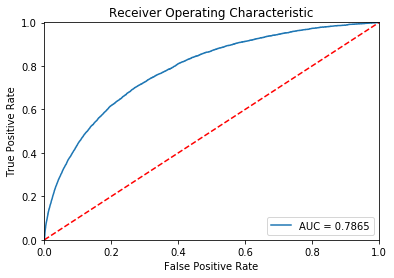

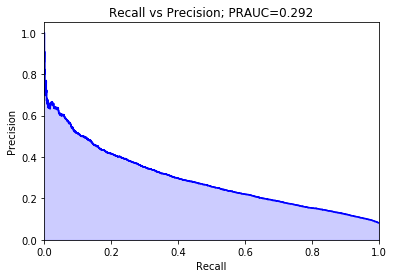

             precision    recall  f1-score   support

   Majority       0.96      0.75      0.84     70621
   Minority       0.19      0.68      0.30      6256

avg / total       0.90      0.75      0.80     76877



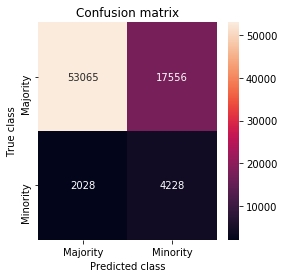

,AUROC,AUPRC,MCC,Precision,Recall,F1
0,0.787,0.292,0.259,0.194,0.676,0.302


In [8]:
simple_experiment_lgb(train_X, train_y, val_X, val_y)